In [1]:
import pandas as pd
import numpy as np
import re, os, string, time
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize

from bs4 import BeautifulSoup
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import timeit
stop_words = stopwords.words('english')
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saurabh.t.singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\saurabh.t.singh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saurabh.t.singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\saurabh.t.singh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saurabh.t.singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
os.chdir(r'C:\Saurabh\Publication')
complaints=pd.read_csv(r'complaints_subset.csv')
len(complaints)

100425

In [3]:
#complaints = complaints.head(50)

In [4]:
#drop unwanted variables
complaints.columns
complaints=complaints[['Complaint ID','Product','Consumer complaint narrative']]
complaints=complaints.fillna('')

In [5]:
## check if there's missing data
print(complaints.isna().sum())
complaints['Product'].value_counts(dropna=False)

Complaint ID                    0
Product                         0
Consumer complaint narrative    0
dtype: int64


Credit reporting               31588
Student loan                   26656
Checking or savings account    23343
Credit card                    18838
Name: Product, dtype: int64

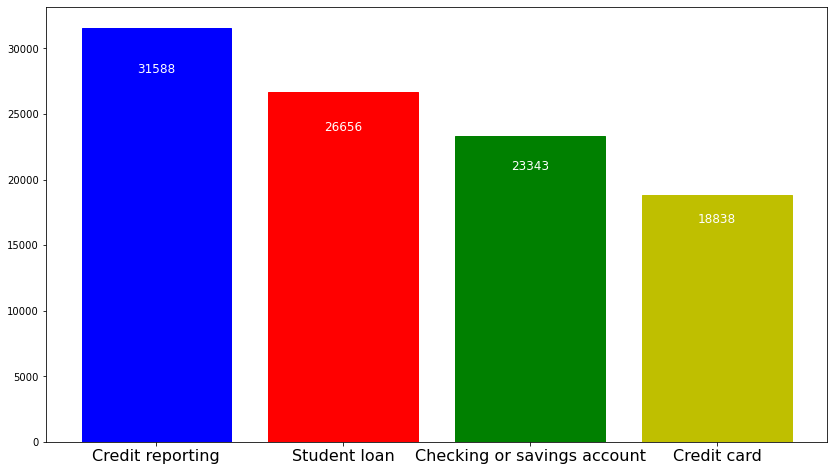

In [6]:
#Inspect the target variable
fig, ax = plt.subplots(1,1,figsize=(14,8))
dimension_vc = complaints['Product'].value_counts()
ax.bar(range(4), dimension_vc) 
ax.set_xticks(range(4))
ax.set_xticklabels(dimension_vc.index, fontsize=16)

for rect, c, value in zip(ax.patches, ['b', 'r', 'g', 'y'], dimension_vc.values):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=12, color='white')

In [7]:
# Inspect Consumer complaint narrative variable
document_lengths = np.array(list(map(len, complaints['Consumer complaint narrative'].str.split(' '))))
print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 203.79020164301718.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 5986.


<AxesSubplot:title={'center':'Distribution of number of words'}, xlabel='Number of words'>

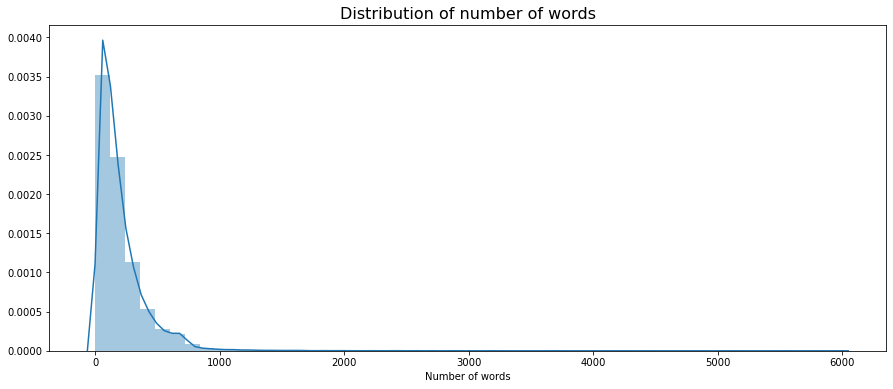

In [8]:
## Distribution of number of words
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax)

In [9]:
print("There are {} documents with over 200 words.".format(sum(document_lengths > 200)))
shorter_documents = document_lengths[document_lengths <= 200]

There are 35882 documents with over 200 words.


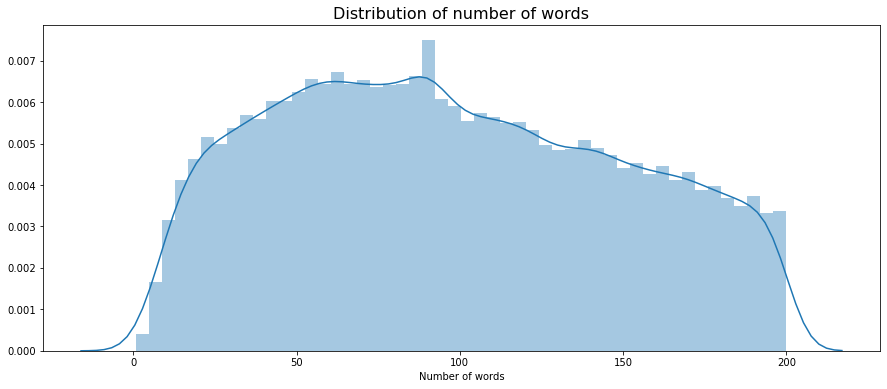

In [10]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

In [11]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths <= 5)))
complaints[document_lengths == 1]

There are 210 documents with tops 5 words.


,Complaint ID,Product,Consumer complaint narrative
816,3204715,Student loan,IhavespokenwithNavientcustomerservicetoaskabou...
1105,3134405,Checking or savings account,ItriedforTHREEhourstobookaflightandpayviadebit...
1208,3185419,Checking or savings account,ThereisnoevidenceofthevalidityoftheXXXXtransac...
1814,3288158,Checking or savings account,I'mpresentlywithRegionBankXXXXXXXXXXXXXXXXXXXX...
2045,3232705,Student loan,MyschoolloanwasthroughSallieMae.ThenIwasinwhat...
2796,3245489,Student loan,IrecentlyreceivedcommunicationfromCFPBindicati...
4479,3314107,Checking or savings account,IhaveanaccountwithCitizensBankandhavehadthisac...
5106,3256626,Checking or savings account,Ihadsubmittedcase#XXXXandhavingthecompanyrestr...
5350,3263889,Student loan,OnXX/XX/2019IreceivedaTotalandPermanentXXXXdis...
5389,3287144,Student loan,"Ihavebeenafederalemployeeforthelast12years,wit..."


In [12]:
#comp1['text']=comp1['text'].str.strip().str.lower()
complaints['document_lengths']=complaints['Consumer complaint narrative'].apply(lambda x:len(x.split()))
complaints.head()

,Complaint ID,Product,Consumer complaint narrative,document_lengths
0,3342225,Student loan,"My sister passed away in California, 47 days l...",224
1,3119955,Student loan,XXXX XXXX refuses to accurately calculate the ...,122
2,3156880,Student loan,My original lender was XXXX XXXX XXXX ; this l...,485
3,3136706,Checking or savings account,Capital One mailed me a closeout check on or a...,551
4,3163988,Student loan,Great Lakes sent my account to a loan service ...,257


In [13]:
#Check words distribution by Target Variable - mean, max, min, std
comp1_dist= pd.pivot_table(complaints, values='document_lengths', index=['Product'], aggfunc={'document_lengths': [np.mean, min, max,np.std]})
comp1_dist

,max,mean,min,std
Product,,,,
Checking or savings account,6014.0,255.400248,1.0,274.953482
Credit card,831.0,207.657713,2.0,164.604975
Credit reporting,840.0,134.937318,2.0,129.306116
Student loan,5421.0,234.205245,1.0,222.908900


<AxesSubplot:xlabel='Product', ylabel='document_lengths'>

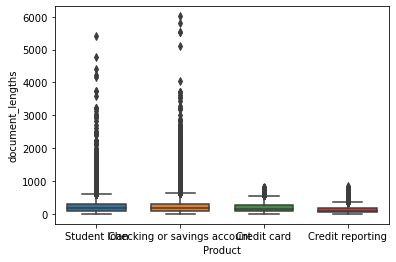

In [14]:
# Word count by class - box plot
sns.boxplot(x='Product',y='document_lengths',data=complaints,width=0.7)
#comp1.boxplot(by ='Product', column =['word_cnt_bef'], grid = False)

In [15]:
from bs4 import BeautifulSoup

In [16]:
#define fucntions for deep cleaning - data normalization
def beauty(raw_text):
    res_text = BeautifulSoup(raw_text, "html.parser").get_text() 
    return res_text
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def tokenize(text):
    text=re.sub('\\n', '. ', text)
    text=re.sub('\s+', ' ', text)
    text = re.sub(r' x+','', text)
    text = re.sub(r' X+','', text)
    text = re.sub(r'^x+ ',' ', text)
    text = re.sub(r'^X+ ','', text)
    result=sent_tokenize(text)
    return result if len(result) else np.NaN

def LemTokens(tokens):
    tokens = [token for token in tokens if token not in stop_words] 
    return [lemmer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

def LemNormalize(text):
     return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

def normalize(sent_list):
    return [" ".join(LemNormalize(s)) for s in sent_list]

In [17]:
complaints['text2']= complaints['Consumer complaint narrative'].apply(beauty)
complaints['text2']= complaints['text2'].apply(tokenize)
complaints['text3']= complaints['text2'].apply(normalize)
complaints['text5'] = complaints['text3'].apply(lambda x: " ".join(x))

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2))
tfidf.fit(complaints['text5'])

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [20]:
# split the dataset into training and validation datasets 
complaints['label'] = complaints['Product'].factorize()[0]
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(complaints['text5'], 
                                                                      complaints['label'], random_state = 123)
train_x =  tfidf.transform(train_x)
valid_x =  tfidf.transform(valid_x)

In [21]:
#SK Learn Pipeline helps to assemble several steps that can be cross-validated together while setting different parameters
### MultonomialNB model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_x, train_y)
from sklearn.metrics import classification_report
pred_y = nb.predict(valid_x)
print('accuracy %s' % metrics.accuracy_score(pred_y, valid_y))
print(classification_report(valid_y, pred_y))

accuracy 0.9138885569761421
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6666
           1       0.90      0.97      0.93      5915
           2       0.95      0.70      0.81      4672
           3       0.89      0.96      0.92      7854

    accuracy                           0.91     25107
   macro avg       0.92      0.90      0.90     25107
weighted avg       0.92      0.91      0.91     25107



In [22]:
### Linear SVM
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=123, max_iter=5, tol=None)
sgd.fit(train_x, train_y)
pred_y = sgd.predict(valid_x)
print('accuracy %s' % metrics.accuracy_score(pred_y, valid_y))
print(classification_report(valid_y, pred_y))

accuracy 0.9115784442585733
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6666
           1       0.91      0.96      0.93      5915
           2       0.94      0.70      0.81      4672
           3       0.87      0.96      0.91      7854

    accuracy                           0.91     25107
   macro avg       0.92      0.90      0.90     25107
weighted avg       0.91      0.91      0.91     25107



In [23]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_x, train_y)
pred_y = sgd.predict(valid_x)
print('accuracy %s' % metrics.accuracy_score(pred_y, valid_y))
print(classification_report(valid_y, pred_y))

accuracy 0.9115784442585733
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6666
           1       0.91      0.96      0.93      5915
           2       0.94      0.70      0.81      4672
           3       0.87      0.96      0.91      7854

    accuracy                           0.91     25107
   macro avg       0.92      0.90      0.90     25107
weighted avg       0.91      0.91      0.91     25107



C:\Users\saurabh.t.singh\anaconda3\envs\bert36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
from gensim.corpora import Dictionary
from sklearn.preprocessing import LabelEncoder
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec

In [25]:
#Check number of sentences will be used for word2vec model
sentences = []
for sentence_group in complaints['text3']:
    sentences.extend(sentence_group)
print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(complaints['text3'])))

Number of sentences: 1156941.
Number of texts: 100425.


In [26]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [27]:
#Word2Vec feature inspection - Let's first create the word2vec features
def get_w2v_features(w2v_model, words):
    #words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    nwords = 0
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

#complaints['w2v_features'] = list(map(lambda sen_group:
#                                      get_w2v_features(W2Vmodel, sen_group), complaints['text3']))

complaints['w2v_features'] = complaints['text5'].apply(lambda x: list(get_w2v_features(W2Vmodel, x)))

C:\Users\saurabh.t.singh\anaconda3\envs\bert36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [28]:
X_train_w2v = np.array(list(map(np.array, complaints['w2v_features'])))        
X = X_train_w2v
y = complaints['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [29]:
### MultonomialNB model
#Normalize features to [0, 1] range to Negative Values or use GaussianNB
from sklearn.naive_bayes import GaussianNB
nb = Pipeline([('clf', GaussianNB()),])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.4856858352003983
              precision    recall  f1-score   support

           0       0.73      0.50      0.59      5334
           1       0.54      0.37      0.44      4730
           2       0.27      0.69      0.39      3711
           3       0.75      0.44      0.55      6310

    accuracy                           0.49     20085
   macro avg       0.57      0.50      0.49     20085
weighted avg       0.61      0.49      0.51     20085



In [30]:
### Linear SVM
from sklearn.linear_model import SGDClassifier
sgd = Pipeline([('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=123, max_iter=5, tol=None)),])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.576201145133184
              precision    recall  f1-score   support

           0       0.58      0.64      0.61      5334
           1       0.69      0.55      0.61      4730
           2       0.80      0.01      0.02      3711
           3       0.53      0.87      0.66      6310

    accuracy                           0.58     20085
   macro avg       0.65      0.52      0.48     20085
weighted avg       0.63      0.58      0.52     20085



In [31]:
### Logistic Regression 
from sklearn.linear_model import LogisticRegression
logreg = Pipeline([('clf', LogisticRegression(n_jobs=1, C=1e5)),])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6839432412247947
              precision    recall  f1-score   support

           0       0.70      0.77      0.74      5334
           1       0.69      0.70      0.69      4730
           2       0.59      0.41      0.49      3711
           3       0.70      0.76      0.73      6310

    accuracy                           0.68     20085
   macro avg       0.67      0.66      0.66     20085
weighted avg       0.68      0.68      0.68     20085



C:\Users\saurabh.t.singh\anaconda3\envs\bert36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [32]:
complaints.columns

Index(['Complaint ID', 'Product', 'Consumer complaint narrative',
       'document_lengths', 'text2', 'text3', 'text5', 'label', 'w2v_features'],
      dtype='object')

In [33]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
sentences = list(complaints['Consumer complaint narrative'])
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

(100425, 768)

In [34]:
sentence_embeddings_df = pd.DataFrame(sentence_embeddings)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings_df, complaints[['label']], test_size=0.2, random_state = 123)

In [36]:
### MultonomialNB model
#Normalize features to [0, 1] range to Negative Values or use GaussianNB
from sklearn.naive_bayes import GaussianNB
nb = Pipeline([('clf', GaussianNB()),])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

C:\Users\saurabh.t.singh\anaconda3\envs\bert36\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy 0.7518048294747324
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5334
           1       0.79      0.75      0.77      4730
           2       0.56      0.58      0.57      3711
           3       0.76      0.78      0.77      6310

    accuracy                           0.75     20085
   macro avg       0.74      0.74      0.74     20085
weighted avg       0.75      0.75      0.75     20085



In [37]:
### Linear SVM
from sklearn.linear_model import SGDClassifier
sgd = Pipeline([('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=123, max_iter=5, tol=None)),])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

C:\Users\saurabh.t.singh\anaconda3\envs\bert36\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy 0.8827483196415236
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      5334
           1       0.86      0.91      0.88      4730
           2       0.86      0.69      0.77      3711
           3       0.89      0.91      0.90      6310

    accuracy                           0.88     20085
   macro avg       0.88      0.87      0.87     20085
weighted avg       0.88      0.88      0.88     20085



In [38]:
### Logistic Regression 
from sklearn.linear_model import LogisticRegression
logreg = Pipeline([('clf', LogisticRegression(n_jobs=1, C=1e5)),])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

C:\Users\saurabh.t.singh\anaconda3\envs\bert36\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\saurabh.t.singh\anaconda3\envs\bert36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.8901170027383619
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5334
           1       0.89      0.89      0.89      4730
           2       0.81      0.78      0.79      3711
           3       0.90      0.91      0.91      6310

    accuracy                           0.89     20085
   macro avg       0.88      0.88      0.88     20085
weighted avg       0.89      0.89      0.89     20085

